In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/kaggle/nih-chest-xrays-tfrecords.zip", 'r')
zip_ref.extractall("/content/nih-chest-xrays-tfrecords")
zip_ref.close()

In [3]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.7 MB 4.1 MB/s 
     |████████████████████████████████| 180 kB 51.7 MB/s 
     |████████████████████████████████| 140 kB 46.3 MB/s 
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=63a4733d3f11236b609cc4e08e08a2fa058f9a9f86363e7b4f7810d228457eef
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=1d1196b72c4ada493ce5fff9e7993484376983b9ddaea3dd4d84d5aa5c7d6816
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [4]:
wandb.init(project="data-science-420-final-project")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## DS420 Final Project
## NIH Chest X-RAY Image Disease Classification

#### Team members: Yordanos Alemu, Kelsey Dinndorf, Jorania Ferreria Alves, & Rabab Mohamed Nafe

Data: https://www.kaggle.com/nickuzmenkov/nih-chest-xrays-tfrecords?select=preprocessed_data.csv

The dataset includes chest x-ray images to classify different diagnoses of diseases. There are 15 categories of diagnosis and 256 images (600 x 600). Additional patient information like age, sex, etc. are not included.

Disease Categories: None, Atelectasis, Consolidation, Infiltration, Pneumothorax, Edema, Emphysema, Fibrosis, Effusion, Pneumonia, Pleural Thickening, Cardiomegaly, Nodule, Mass, Hernia

In [5]:
#import libraries

import numpy as np 
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/nih-chest-xrays-tfrecords'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/nih-chest-xrays-tfrecords/preprocessed_data.csv
/content/nih-chest-xrays-tfrecords/data/053-438.tfrec
/content/nih-chest-xrays-tfrecords/data/120-438.tfrec
/content/nih-chest-xrays-tfrecords/data/096-438.tfrec
/content/nih-chest-xrays-tfrecords/data/088-438.tfrec
/content/nih-chest-xrays-tfrecords/data/196-438.tfrec
/content/nih-chest-xrays-tfrecords/data/098-438.tfrec
/content/nih-chest-xrays-tfrecords/data/009-438.tfrec
/content/nih-chest-xrays-tfrecords/data/081-438.tfrec
/content/nih-chest-xrays-tfrecords/data/069-438.tfrec
/content/nih-chest-xrays-tfrecords/data/202-438.tfrec
/content/nih-chest-xrays-tfrecords/data/172-438.tfrec
/content/nih-chest-xrays-tfrecords/data/119-438.tfrec
/content/nih-chest-xrays-tfrecords/data/199-438.tfrec
/content/nih-chest-xrays-tfrecords/data/213-438.tfrec
/content/nih-chest-xrays-tfrecords/data/219-438.tfrec
/content/nih-chest-xrays-tfrecords/data/040-438.tfrec
/content/nih-chest-xrays-tfrecords/data/177-438.tfrec
/content/nih-chest-xrays-

### Exploratory Data Analysis and Visualization

In [6]:
# Read the disease csv file (contains True/False)
df= pd.read_csv('/content/nih-chest-xrays-tfrecords/preprocessed_data.csv')
df.head()

,Unnamed: 0,No Finding,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,../input/data/images_001/images/00000001_000.png,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,../input/data/images_001/images/00000001_001.png,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
2,../input/data/images_001/images/00000001_002.png,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
3,../input/data/images_001/images/00000002_000.png,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,../input/data/images_001/images/00000003_000.png,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [7]:
#Define disease categories as data
data= df.iloc[:,1:]

In [8]:
data

,No Finding,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
3,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
112116,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
112117,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
112118,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [9]:
#Show data shape
df.shape

#There are 16 columns and 112,120 rows

(112120, 16)

In [10]:
# Show data info
df.info()

#There are no missing values
#all of the attributes are type boolean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Unnamed: 0          112120 non-null  object
 1   No Finding          112120 non-null  bool  
 2   Atelectasis         112120 non-null  bool  
 3   Consolidation       112120 non-null  bool  
 4   Infiltration        112120 non-null  bool  
 5   Pneumothorax        112120 non-null  bool  
 6   Edema               112120 non-null  bool  
 7   Emphysema           112120 non-null  bool  
 8   Fibrosis            112120 non-null  bool  
 9   Effusion            112120 non-null  bool  
 10  Pneumonia           112120 non-null  bool  
 11  Pleural_Thickening  112120 non-null  bool  
 12  Cardiomegaly        112120 non-null  bool  
 13  Nodule              112120 non-null  bool  
 14  Mass                112120 non-null  bool  
 15  Hernia              112120 non-null  bool  
dtypes:

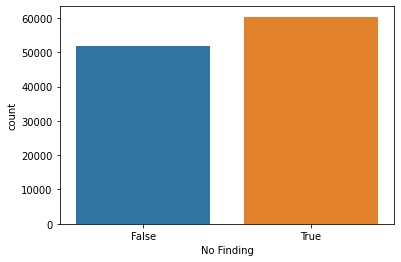

In [11]:
# Countplot of No finding category
sns.countplot(x='No Finding', data=df)

In [12]:
#define data columns, number of columns, and character columns
cols = data.columns
num_cols = data._get_numeric_data().columns
char_cols=list(set(cols) - set(num_cols))
char_cols

[]

In [13]:
# 1-hot encoding
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
def encode(df):
    for i in cols:
        df[i]= le.fit_transform(df[i])
    return df

In [14]:
#1-hot encode the disease categories
encode(data)

,No Finding,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
112116,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112117,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
112118,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
#concat the original image urls with the 1-hot encoded data
df=pd.concat([df.iloc[:,0],data], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd25efbe5d0>,
      dtype=object)

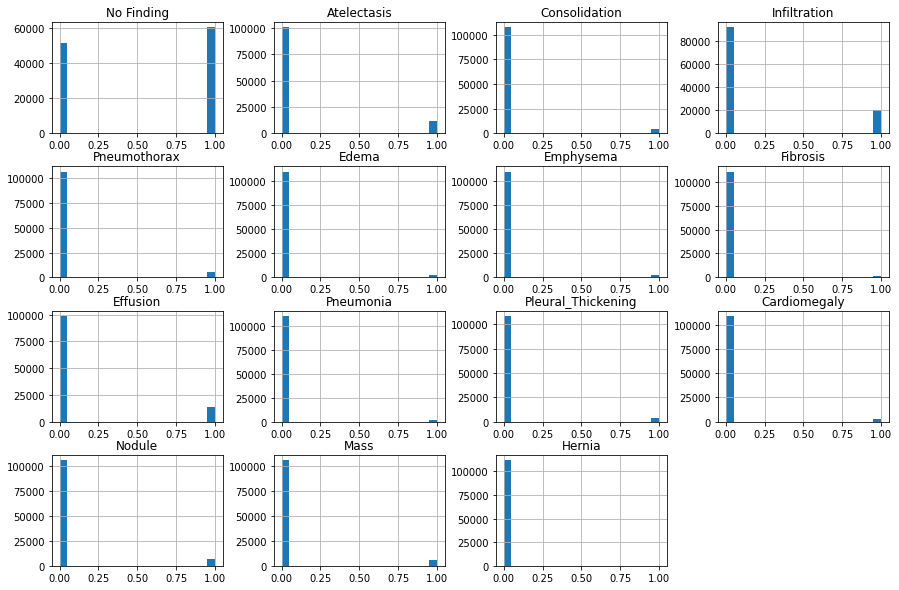

In [16]:
#Histogram of disease types
data.hist(bins=20, figsize=(15,10))

In [17]:
#import libraries
import IPython.display as display
import random
from functools import partial
import sys
from numpy import load
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
import time as timer

'\nThere are large correlations between the No Finding category an most of the other categories.\nThere is a fairly large correlation (0.18) between Emphysema and Pneumothorax.\nThere is a fairly large correlation (0.17) between Pneumonia and Edema.\nThere is a fairly large correlation (0.17) between Atelectasis and Effusion.\n'

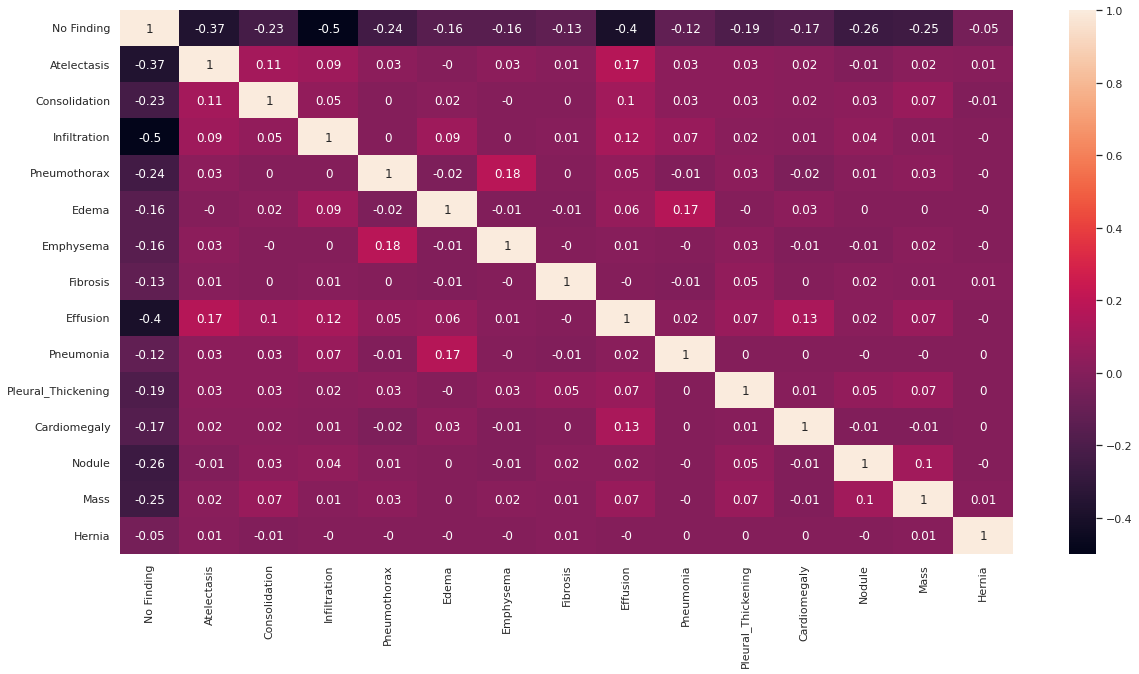

In [18]:
# Correlation matrix
sns.set(rc={'figure.figsize':(20,10)})
correlation_matrix = data.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)

'''
There are large correlations between the No Finding category an most of the other categories.
There is a fairly large correlation (0.18) between Emphysema and Pneumothorax.
There is a fairly large correlation (0.17) between Pneumonia and Edema.
There is a fairly large correlation (0.17) between Atelectasis and Effusion.
'''

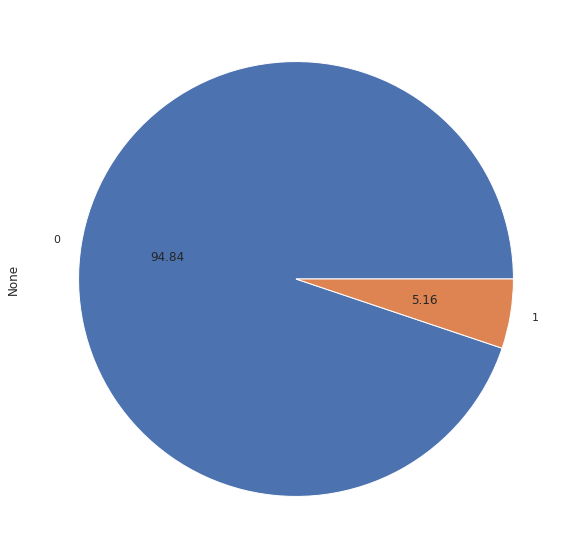

In [19]:
# Pie chart of percent of x-ray images classified as a Mass disease
df.groupby('Mass').size().plot(kind='pie', autopct='%.2f')

# 5.16% of the x-ray images are classified as Mass

In [20]:
# Define list of column headers
heads = list(df.columns)[2:]
heads

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia']

### Split Image

In [21]:
file_loc = '/content/nih-chest-xrays-tfrecords/'

image_loc = file_loc + 'data/'

image = os.listdir(image_loc)

print('The total images in TFRecord is ' + str(len(image)) + ' x-ray images')

#There are 256 images

The total images in TFRecord is 256 x-ray images


In [22]:
img = [image_loc + x for x in image]

file_name = tf.io.gfile.glob(img)

Randomly sample the entire list to a 80-20% split, then set aside 10% of the train sets randomly as a validation set.

In [23]:
#Define training and test sets (index)
ALL = list(range(len(file_name)))

train_valid = random.sample(ALL, int(len(ALL) * 0.8))
test_index = list(set(ALL) - set(train_valid))

train_index = random.sample(train_valid, int(len(train_valid) * 0.9))
valid_index = list(set(train_valid) - set(train_index))

In [24]:
#Define training and test image file names
TRAINING_FILENAMES, VALID_FILENAMES, TEST_FILENAMES = [file_name[index] for index in train_index], [file_name[index] for index in valid_index], [file_name[index] for index in test_index]
TRAINING_FILENAMES

['/content/nih-chest-xrays-tfrecords/data/066-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/135-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/016-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/061-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/193-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/251-437.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/154-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/167-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/037-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/240-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/163-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/122-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/192-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/219-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/242-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/236-438.tfrec',
 '/content/nih-chest-xrays-tfrecords/data/012-438.tfrec',
 '/content/nih

In [25]:
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

Train TFRecord Files: 183
Validation TFRecord Files: 21
Test TFRecord Files: 52


### Reducing Image Dimensionality

In [26]:
feature_description = {}

for elem in list(df.columns)[2:]:
    feature_description[elem] = tf.io.FixedLenFeature([], tf.int64)
    
feature_description['image'] = tf.io.FixedLenFeature([], tf.string)

Here we are reducing the image size to 50 X 50 

In [27]:
BATCH_SIZE = 32
IMAGE_ONE_AXIS = 50
IMAGE_SIZE = [IMAGE_ONE_AXIS, IMAGE_ONE_AXIS]
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [28]:
# Functions to read the data
def read_tfrecord(example):
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example["image"], channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    
    label = []
    
    for val in heads:
        label.append(example[val])
    
    return image, label

In [29]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    
    return dataset

In [30]:
def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

In [31]:
#Define train, valid, and test datasets
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_dataset(TEST_FILENAMES)

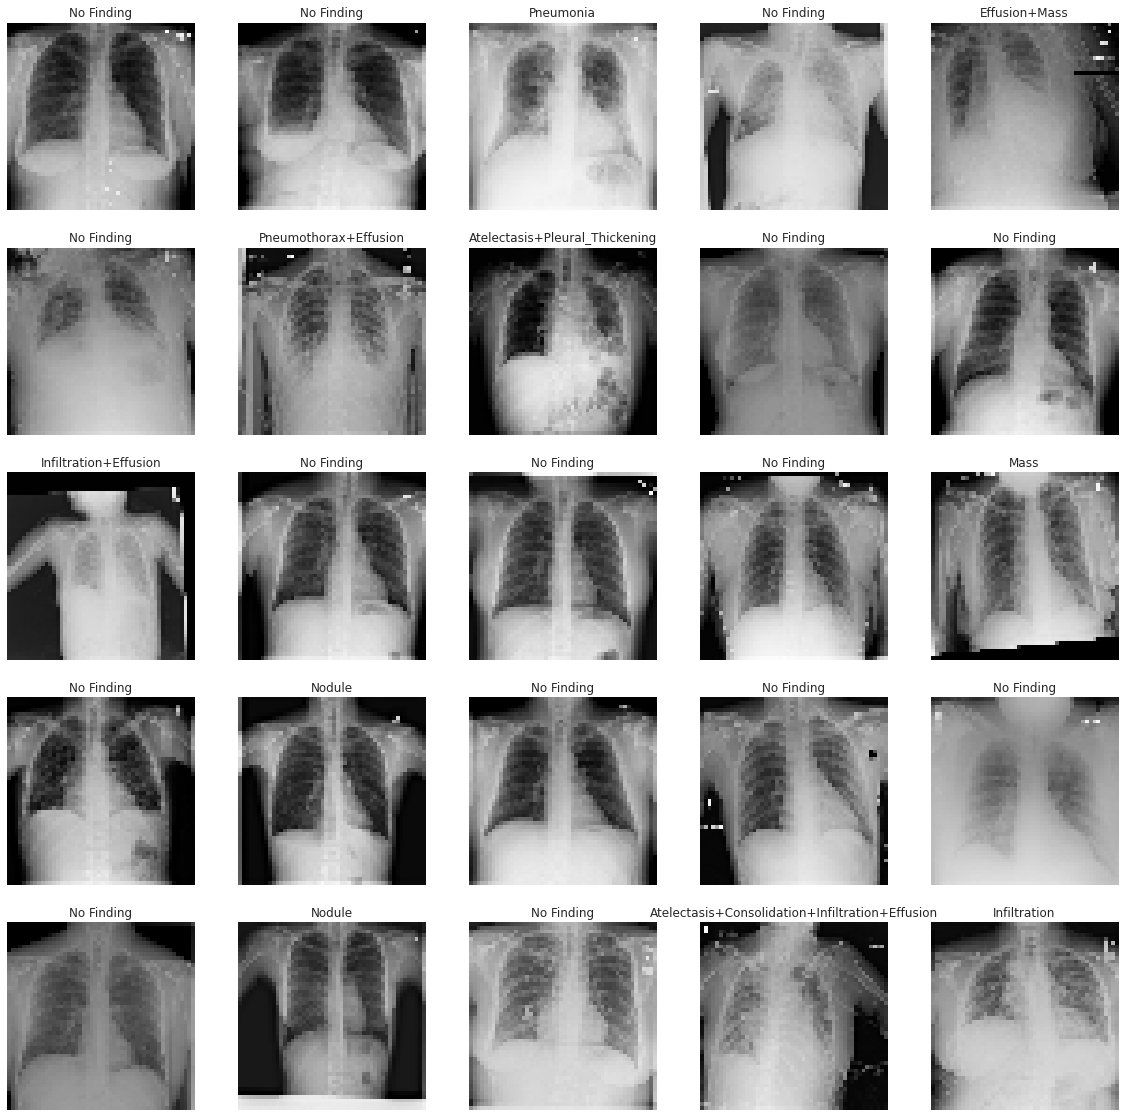

In [32]:
#Show the images for the training set to visualize
image_viz, label_viz = next(iter(train_dataset))

def show_batch(X, Y):
    plt.figure(figsize=(20, 20))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(X[n])
        
        result = [x for i, x in enumerate(heads) if Y[n][i]]
        title = "+".join(result)
        
        if result == []: title = "No Finding"
        
        plt.title(title)
        plt.axis("off")

show_batch(image_viz.numpy(), label_viz.numpy())

In [33]:
image_viz.numpy()

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.04160781, 0.04160781, 0.04160781],
         ...,
         [0.16647059, 0.16647059, 0.16647059],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.108     , 0.108     , 0.108     ]

In [34]:
label_viz.numpy()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0,

# PCA Model:

In [35]:
from PIL import Image
from IPython.display import display
display(image)

['053-438.tfrec',
 '120-438.tfrec',
 '096-438.tfrec',
 '088-438.tfrec',
 '196-438.tfrec',
 '098-438.tfrec',
 '009-438.tfrec',
 '081-438.tfrec',
 '069-438.tfrec',
 '202-438.tfrec',
 '172-438.tfrec',
 '119-438.tfrec',
 '199-438.tfrec',
 '213-438.tfrec',
 '219-438.tfrec',
 '040-438.tfrec',
 '177-438.tfrec',
 '187-438.tfrec',
 '139-438.tfrec',
 '251-437.tfrec',
 '205-438.tfrec',
 '051-438.tfrec',
 '052-438.tfrec',
 '111-438.tfrec',
 '080-438.tfrec',
 '031-438.tfrec',
 '169-438.tfrec',
 '211-438.tfrec',
 '090-438.tfrec',
 '033-438.tfrec',
 '084-438.tfrec',
 '123-438.tfrec',
 '034-438.tfrec',
 '235-438.tfrec',
 '103-438.tfrec',
 '224-438.tfrec',
 '086-438.tfrec',
 '167-438.tfrec',
 '017-438.tfrec',
 '042-438.tfrec',
 '059-438.tfrec',
 '044-438.tfrec',
 '250-437.tfrec',
 '234-438.tfrec',
 '171-438.tfrec',
 '091-438.tfrec',
 '225-438.tfrec',
 '191-438.tfrec',
 '153-438.tfrec',
 '201-438.tfrec',
 '087-438.tfrec',
 '209-438.tfrec',
 '083-438.tfrec',
 '125-438.tfrec',
 '193-438.tfrec',
 '050-438.

In [36]:
'''# Read and print data:
sess=tf.compat.v1.InteractiveSession()

# Read TFRecord file
reader = tf.compat.v1.TFRecordReader()
#tf.compat.v1.python_io
filename_queue = tf.train.string_input_producer(['180-438.tfrec'])
_, serialized_example = reader.read(filename_queue)

# Define features
read_features = {
    'image/height': tf.FixedLenFeature([], dtype=tf.int64),
    'image/width': tf.FixedLenFeature([], dtype=tf.int64),
    'image/colorspace': tf.FixedLenFeature([], dtype=tf.string),
    'image/class/label': tf.FixedLenFeature([], dtype=tf.int64),
    'image/class/raw': tf.FixedLenFeature([], dtype=tf.int64),
    'image/class/source': tf.FixedLenFeature([], dtype=tf.int64),
    'image/class/text': tf.FixedLenFeature([], dtype=tf.string),
    'image/format': tf.FixedLenFeature([], dtype=tf.string),
    'image/filename': tf.FixedLenFeature([], dtype=tf.string),
    'image/id': tf.FixedLenFeature([], dtype=tf.int64),
    'image/encoded': tf.FixedLenFeature([], dtype=tf.string)
}

# Extract features from serialized data
read_data = tf.parse_single_example(serialized=serialized_example,
                                features=read_features)

# Many tf.train functions use tf.train.QueueRunner,
# so we need to start it before we read
tf.train.start_queue_runners(sess)

# Print features
for name, tensor in read_data.items():
    print('{}: {}'.format(name, tensor.eval()))
    '''

"# Read and print data:\nsess=tf.compat.v1.InteractiveSession()\n\n# Read TFRecord file\nreader = tf.compat.v1.TFRecordReader()\n#tf.compat.v1.python_io\nfilename_queue = tf.train.string_input_producer(['180-438.tfrec'])\n_, serialized_example = reader.read(filename_queue)\n\n# Define features\nread_features = {\n    'image/height': tf.FixedLenFeature([], dtype=tf.int64),\n    'image/width': tf.FixedLenFeature([], dtype=tf.int64),\n    'image/colorspace': tf.FixedLenFeature([], dtype=tf.string),\n    'image/class/label': tf.FixedLenFeature([], dtype=tf.int64),\n    'image/class/raw': tf.FixedLenFeature([], dtype=tf.int64),\n    'image/class/source': tf.FixedLenFeature([], dtype=tf.int64),\n    'image/class/text': tf.FixedLenFeature([], dtype=tf.string),\n    'image/format': tf.FixedLenFeature([], dtype=tf.string),\n    'image/filename': tf.FixedLenFeature([], dtype=tf.string),\n    'image/id': tf.FixedLenFeature([], dtype=tf.int64),\n    'image/encoded': tf.FixedLenFeature([], dtype=tf

## Tree Classification Model (Machine Learning)

In [37]:
# Import libraries
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics

In [38]:
#Define y as response (No Finding category)
y = data.iloc[:32, :1]
y

,No Finding
0,0
1,0
2,0
3,1
4,0
5,0
6,0
7,0
8,0
9,0


In [39]:
#define y as numpy array
y = y.values
y

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1]])

In [40]:
# Define x as explanatory variables
x = image_viz

In [41]:
#Check shape of x
x.shape

TensorShape([32, 50, 50, 3])

In [42]:
#Check shape of y
y.shape

(32, 1)

In [43]:
#convert x tensor to an array
proto_tensor = tf.make_tensor_proto(image_viz)  # convert `tensor a` to a proto tensor
x = tf.make_ndarray(proto_tensor) 

# output has shape (2,3)

In [44]:
x.shape

(32, 50, 50, 3)

In [45]:
#reshape x from 4D to 2D
reshaped = x.reshape(32, 7500)
reshaped.shape

(32, 7500)

In [46]:
# define the explanatory data as newx
newx=reshaped

In [47]:
#Check shape
print(newx.shape)
print(y.shape)

(32, 7500)
(32, 1)


In [48]:
# Split the train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(newx,y, test_size = 0.2, random_state = 4)
print('Train set:', x_train.shape)
print('Test set:', x_test.shape)
print('Train set:', y_train.shape)
print('Test set:', y_test.shape)

Train set: (25, 7500)
Test set: (7, 7500)
Train set: (25, 1)
Test set: (7, 1)


In [49]:
# Decision Tree classifier
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [50]:
#Accuracy evaluation
y_predict=tree_clf.predict(x_test)

print("Train set Accuracy: ", metrics.accuracy_score(y_train, tree_clf.predict(x_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_predict))

Train set Accuracy:  1.0
Test set Accuracy:  0.42857142857142855


Using a Decision Tree Classifier to classify the images as No Disease Finding or Yes Disease found gave a training set accuracy of 100%. The test set accuracy is about 42%, so this model is not great at predicting the disease based on the x-ray images.

In [51]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_predict)
print(cm)

[[1 3]
 [1 2]]


# CNN Model:

In [52]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=5, decay_rate=0.96, staircase=True
)


In [53]:
def define_model(in_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), out_shape=len(heads)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))
    
    config = wandb.config
    config.learning_rate = 0.01
    model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=lr_schedule),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name="auc")])
    return model

In [54]:
train_size = sum(1 for _ in tf.data.TFRecordDataset(TRAINING_FILENAMES))
validation_size = sum(1 for _ in tf.data.TFRecordDataset(VALID_FILENAMES))

epoch_steps = int(np.ceil(train_size/BATCH_SIZE))
validation_steps = int(np.ceil(validation_size/BATCH_SIZE))

epochs = 5

print("steps_per_epoch: " + str(epoch_steps))
print("validation_steps: " + str(validation_steps))

steps_per_epoch: 2505
validation_steps: 288


In [55]:
model = define_model()

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    validation_steps = validation_steps,callbacks=[WandbCallback()]
)

Epoch 1/5
2505/2505 [==============================] - 272s 94ms/step - loss: 0.1917 - auc: 0.7129 - val_loss: 0.1893 - val_auc: 0.7156
Epoch 2/5
2505/2505 [==============================] - 256s 101ms/step - loss: 0.1869 - auc: 0.7220 - val_loss: 0.1893 - val_auc: 0.7156
Epoch 3/5
2505/2505 [==============================] - 242s 94ms/step - loss: 0.1869 - auc: 0.7220 - val_loss: 0.1893 - val_auc: 0.7156
Epoch 4/5
2505/2505 [==============================] - 241s 94ms/step - loss: 0.1869 - auc: 0.7220 - val_loss: 0.1893 - val_auc: 0.7156
Epoch 5/5
2505/2505 [==============================] - 240s 94ms/step - loss: 0.1869 - auc: 0.7220 - val_loss: 0.1893 - val_auc: 0.7156


In [56]:
_, test_auc = model.evaluate(test_dataset, verbose=0)

test_acc = model.evaluate(test_dataset)
print('Test auc:', test_auc)
print('Test :', test_acc)

712/712 [==============================] - 52s 67ms/step - loss: 0.1860 - auc: 0.7230
Test auc: 0.7230204343795776
Test : [0.18603891134262085, 0.7230204343795776]


The CNN model gives an accuracy of 70% when predicting x-ray images.

## Conclusions

Conclusion:

The model used for Machine Learning is the Tree Classifier 

The final model for tree classifier we decided to use only what category which is “Finding”, the values in this column are stating whether or not there is a disease detected instead of including all 15 categories.

The accuracy from the tree classifier model gave us 100% from the training set accuracy, while for test set the accuracy was about 27%.This suggests that in the training set it appears to be some oversampling because it is not likely that the model can predict 100% accuracy


The model used for Deep Learning is the CNN model

The accuracy from the CNN model 74% to classify the disease images. This shows that the deep learning model (CNN) performed better than the decision tree.

While working on the project there are some issues that we ran through like PCA
We tried to apply PCA but we encountered some problems when converting the image files from tfrec to jpeg.

Further Improvement:

We could try to implement PCA model and using all the categories to see how the model accuracy changes for both Tree Classifier and CNN



Reference: 
https://www.kaggle.com/hemanthhari/cv-hemanth
